In [1]:
import mxnet as mx
import gluoncv as gcv
import numpy as np
import matplotlib.pyplot as plt
import myutils
import importlib
import yolo_utils

In [45]:
class Dataset(mx.gluon.data.Dataset):
    def __init__(self, filename):
        super(Dataset, self).__init__()
        import os
        
        windows_dataset_root = r'D:\Documents\Data_Files\Pascal'
        windows_dataset_root2 = r'h:\hlc\Datasets\Pascal'
        linux_dataset_root = '../Dataset/Pascal'
        dataset_root = windows_dataset_root
        img_idx_directory = os.path.sep.join([dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'ImageSets', 'Main'])
        self.img_directory = os.path.sep.join([dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'JPEGImages'])
        self.annotation_directory = os.path.sep.join([dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'Annotations'])
        self.class_name = filename.split('_')[0]
        
        self.img_indices = []
        with open (os.path.sep.join([img_idx_directory, filename]), 'r') as f:
            import re
            import os
            regex = re.compile ('[ ]+')
            while(True):
                line = f.readline()
                if line == '':
                    break
                img_idx, in_the_class = regex.split(line.rstrip('\n'))
                in_the_class = int(in_the_class)
                if (in_the_class == 1):
                    self.img_indices.append(img_idx)
        self.len = len(self.img_indices)
        return


    def __getitem__(self, idx):
        import os
        import mxnet as mx
        import xml.etree.ElementTree as et
        
        img_path = os.path.sep.join([self.img_directory, str(self.img_indices[idx])+'.jpg'])
        img = mx.image.imread(img_path)
        
        label_path = os.path.sep.join([self.annotation_directory, str(self.img_indices[idx])+'.xml'])
        tree = et.parse(label_path)
        root = tree.getroot()
        obj_iter = root.iterfind('object')
        for obj in obj_iter:
            if (obj.find('name').text == self.class_name):
                bndbox = obj.find('bndbox')
                coors = mx.nd.array([int(coor.text) for coor in bndbox])
                label = mx.nd.concat(mx.nd.array([1]), coors, dim=0)
                label = label.reshape(shape=(1, 5))
        return img.asnumpy(), label.astype('int').asnumpy()
    
    
    def __len__(self):
        return self.len
    

dataset = Dataset('cat_train.txt')
print('total num of data entries:', len(dataset))

total num of data entries: 163


In [3]:
batch_size = 10
dataset_for_train = dataset.transform(myutils.transform_fn)
dataloader = mx.gluon.data.DataLoader(dataset_for_train, batch_size=batch_size, shuffle=True)
batchiter = iter(dataloader)
batch_img, batch_label = next(batchiter)
print(batch_img.shape)
print(batch_label.shape)

(10, 3, 300, 300)
(10, 1, 5)


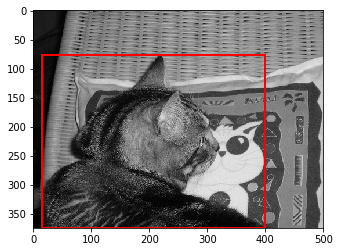

In [46]:
img, label = dataset[3]
myutils.data_visualize(img=img, bboxes=label[:, 1:])

## 生成 yolo 的一个 target

最后生成的 shape 是$S \times S \times (B * 5 + C)$，令$S = 7$，$B = 2$，$C = 20$

In [282]:
importlib.reload(yolo_utils)

<module 'yolo_utils' from 'D:\\Documents\\Git\\yolo_v1\\yolo_utils.py'>

In [236]:
def generate_random_box():
    while True:
        box = np.random.uniform(0, 1, size=(4, ))
        if box[0] < box[2] and box[1] < box[3]:
            break
    return box.reshape((1, 4))

def generate_random_pred_tensor():
    boxes = np.empty(shape=(2, 4))
    for i in range(2):
        boxes[i] = generate_random_box()
    print(boxes)
    pred_tensor = np.random.uniform(size=(7, 7, 30))
    pred_tensor[4, 2, 0:4] = boxes[0]
    pred_tensor[4, 2, 5:9] = boxes[1]
    return pred_tensor

`mx.nd.contrib.box_iou(boxes_1, boxes_2)`

`boxes_1`: mx.nd.array, float32, (N_1, 4)

`boxes_2`: mx.nd.array, float32, (N_2, 4)

`return`: iou, mx.nd.array, float32, (N_1, N_2) 

建议把 reference box 写在第二个位置，这样产生出来的 iou 的 shape 比较舒服。

[[0.46416377 0.15392205 0.88789385 0.44120033]
 [0.04656857 0.96256308 0.14338427 0.99251265]]
boxes pred: [[0.46416377 0.15392205 0.88789385 0.44120033]
 [0.04656857 0.96256308 0.14338427 0.99251265]]
iou: 
[[0.12190039]
 [0.00471063]]
<NDArray 2x1 @cpu(0)>
idx_max_iou: 0
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
yolo label: [1.         0.898      0.20933333 0.772      0.79733333]
tensor_targ:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


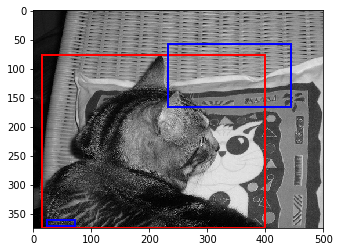

loss: 13.357920132098023


In [284]:
tensor_pred = generate_random_pred_tensor()
tensor_targ = yolo_utils.generate_target(img, label, tensor_pred)
yolo_loss = yolo_utils.calc_yolo_loss(tensor_pred, tensor_targ)

In [ ]:
class Yolo_v1(mx.gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Yolo_v1, self).__init__(**kwargs)
        return
    
    def forward(self, x):
        return

## non-maximum suppression algorithm

这个算法的主要思想是删去那些重合度很高的 bounding boxes，但是并**不做融合**。

steps:

1. 对 boxes 按 score 进行降序排列，挑出 score 最大的那个 box。假设我们把它称为 box_1
2. 分别计算 box_1 和其它 boxes 的 IOU，如果 IOU 值小于 threshold，则保留，否则将其它的那个 box 删除。
3. 现在与 box_1 相关的框已经筛选完毕了，接下来把 box_1 排除在外，挑选剩下的框中，score 最高的那个，并重复步骤2
4. 按照上述方法，不断重复步骤2和3，直到把所有的 boxes 都处理完。

此时所有的 boxes 只有两个去向：要么被保留，要么被删除。被保留下来的，基本上都是离得比较远或 IOU 比较小的 boxes。

nms 效果示例：

```python
import mxnet as mx
import matplotlib.pyplot as plt
import myutils

s = (10, 6)
boxes_with_score = mx.nd.empty(shape=s)
boxes_with_score[:, 2:4] = mx.nd.array([[0.25, 0.25]] * s[0])
boxes_with_score[:, 4:6] = mx.nd.random_normal(loc=0.7, scale=0.2, shape=(s[0], 2))
boxes_with_score[:, 0] = 0
img = mx.nd.uniform(0, 1, shape=(300, 300))
fig = plt.imshow(img.asnumpy())
axes = fig.axes
for box in boxes_with_score:
    myutils._add_rectangle(axes, box[2:].asnumpy())
plt.show()
print('number of raw boxes:', len(boxes_with_score))

output = mx.nd.contrib.box_nms(data=boxes_with_score)

fig = plt.imshow(img.asnumpy())
axes = fig.axes
count_boxes = 0
for box in output:
    if abs(box[0].asscalar() + 1) > 1e-3:
        count_boxes += 1
        myutils._add_rectangle(axes, box[2:].asnumpy(), color='blue')
plt.show()
print('number of boxes filtered:', count_boxes)
```

更详细的资料可以参考[这篇文章](https://medium.com/@chih.sheng.huang821/機器-深度學習-物件偵測-non-maximum-suppression-nms-aa70c45adffa)